In [250]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
import random
import math
import warnings

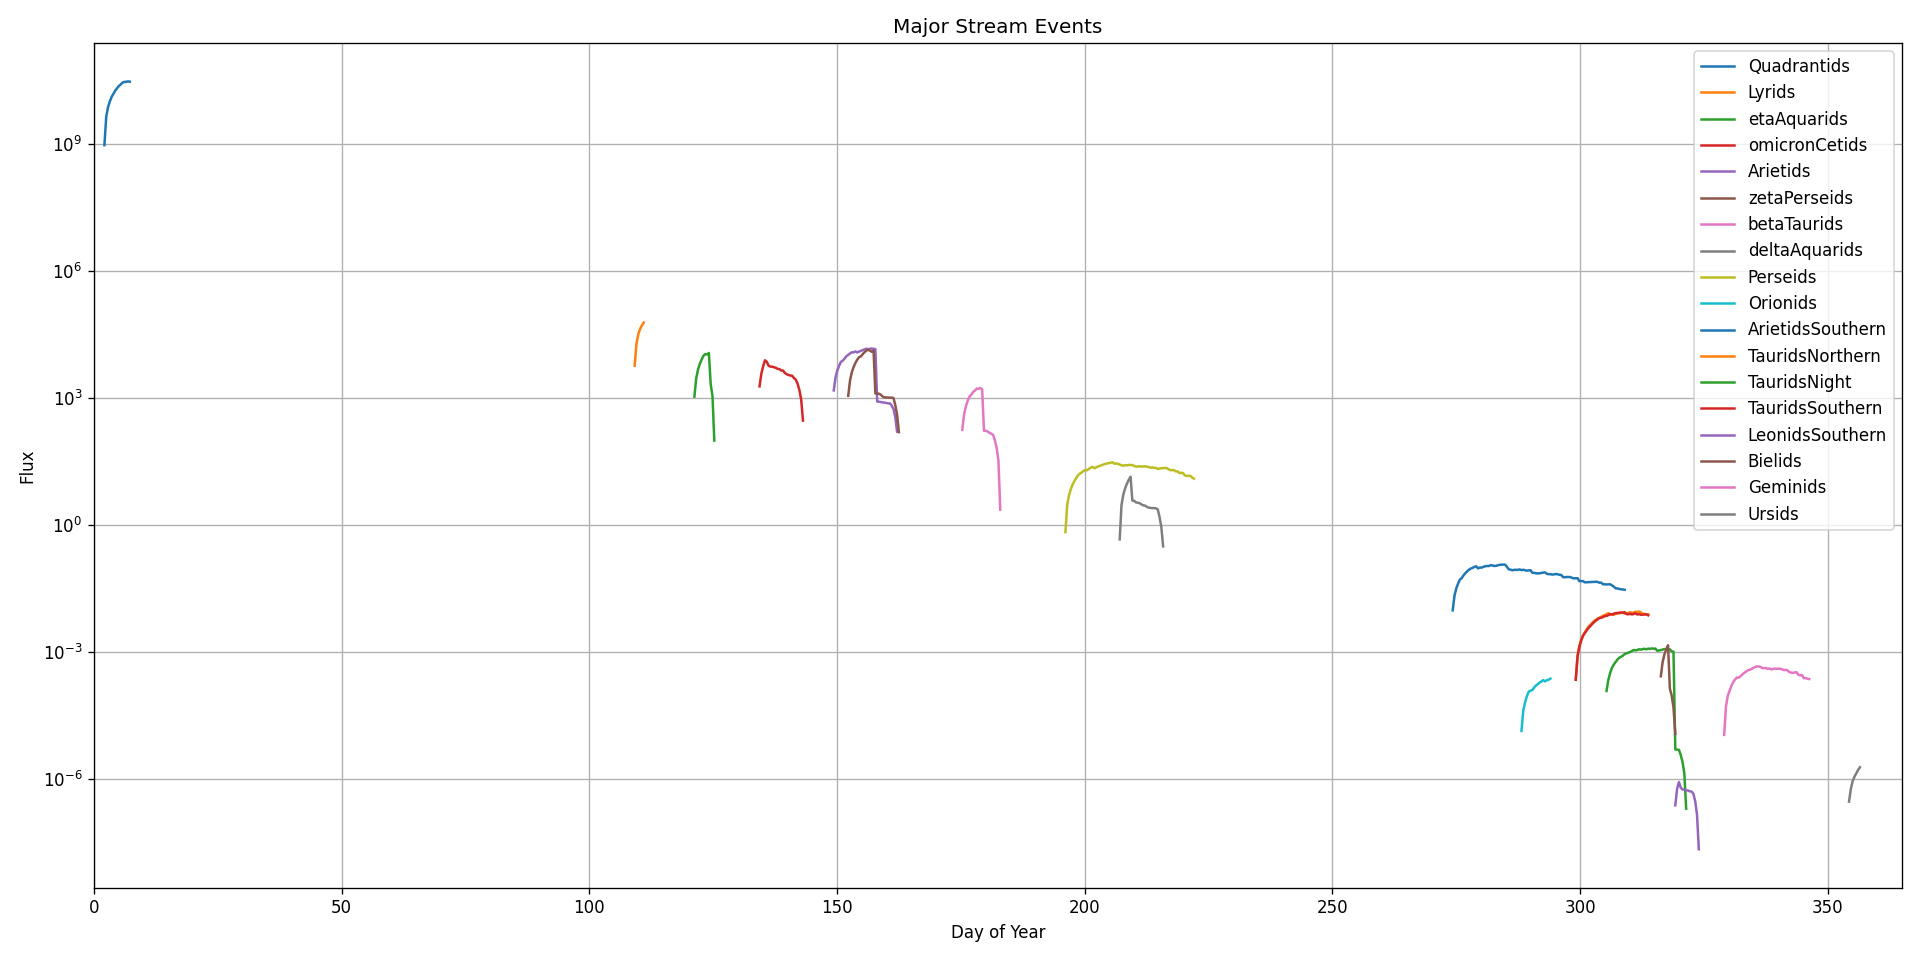

In [253]:
n = 1000
time_vec = np.linspace(1, 366, n)
# create a figure with a single subplot
fig, ax = plt.subplots(figsize=(16, 8), dpi=120, facecolor=(1,1,1))
majorstreamevents = {}

#majorstreamevents['stream name'] = 
#     ['time of occurence (day of year)', 'duration (days)','Increase rate (deg)',
#      'Decrease rate (deg)', Maximum flux ratio, Fmax, Velocity, vst (km/s)]

majorstreameventnames = ['Quadrantids','Lyrids','etaAquarids','omicronCetids','Arietids','zetaPerseids'
                         'betaTaurids','deltaAquarids','Perseids','Orionids','ArietidsSouthern','TauridsNorthern'
                         'TauridsNight','TauridsSouthern','LeonidsSouthern','Bielids','Geminids','Ursids']
        
majorstreamevents['Quadrantids']      = [  2,  2, 82.87,  7.13,  8.0, 42.0]
majorstreamevents['Lyrids']           = [109,  3, 23.03, 49.64, 0.85, 48.0]
majorstreamevents['etaAquarids']      = [121,  7, 36.25, 42.27,  2.2, 64.0]
majorstreamevents['omicronCetids']    = [134,  9,  90.0,  90.0,  2.0, 37.0]
majorstreamevents['Arietids']         = [149, 21, 29.36, 70.91,  4.5, 38.0]
majorstreamevents['zetaPerseids']     = [152, 15, 30.96, 73.30,  3.0, 29.0]
majorstreamevents['betaTaurids']      = [175, 11, 26.57, 74.05,  2.0, 31.0]
majorstreamevents['deltaAquarids']    = [207, 10, 36.87, 79.38,  1.5, 40.0]
majorstreamevents['Perseids']         = [196, 34, 10.89, 38.66,  5.0, 60.0]
majorstreamevents['Orionids']         = [288, 10, 11.31, 39.80,  1.2, 66.0]
majorstreamevents['ArietidsSouthern'] = [274, 58,  3.27, 85.03,  2.0, 28.0]
majorstreamevents['TauridsNorthern']  = [299, 27,  1.53, 88.09,  0.4, 29.0]
majorstreamevents['TauridsNight']     = [305, 29,  4.09, 86.19,  1.0, 37.0]
majorstreamevents['TauridsSouthern']  = [299, 27,  3.43, 85.71,  0.9, 28.0]
majorstreamevents['LeonidsSouthern']  = [319,  5, 41.99, 73.30,  0.9, 72.0]
majorstreamevents['Bielids']          = [316,  4, 11.31, 78.69,  0.4, 16.0]
majorstreamevents['Geminids']         = [329, 22, 13.24,  45.0,  4.0, 35.0]
majorstreamevents['Ursids']           = [354,  4, 51.34, 38.66,  2.5, 37.0]
        
# loop over the major stream events and generate the flux for each one
for event_name, event_params in majorstreamevents.items():
    # extract the event parameters
    t0, duration, alpha1, alpha2, f_max, v_st = event_params
    
    # generate the flux and plot it on the same subplot
    warnings.filterwarnings('ignore')
    flux = sm.generate_CourPalais_flux(time_vec, np.sort(sm.randommassgenerator(n)), t0, duration, alpha1, alpha2, f_max, v_st)
    ax.semilogy(time_vec, flux, label=event_name)

ax.set_xlabel('Day of Year')
ax.set_ylabel('Flux')
ax.set_title('Major Stream Events')
ax.set_xlim([0, 365])
#ax.set_ylim([1 * 10**-6, 1 * 10**12])
ax.legend()

plt.grid()
plt.tight_layout()
plt.show()

Grun Interplanetary Model

In [239]:
class SpaceEnvironmentModel:
    
    def randommassgenerator(self, n, minval=1e-17, maxval=1.0):
        return np.exp(np.random.uniform(np.log(minval), np.log(maxval), size=n))
    
    def MassDensityCriteria(self, m):
        '''
        A relation to the size of the meteoroid and its density is modeled by the following piecewise function. [1] 

                 2.0 [g/cm^3]    for    mass < 10^-6 g
        rho(m) = 1.0 [g/cm^3]    for    10^-6 g <= mass <= 10^-2 g
                 0.5 [g/cm^3]    for    mass > 10^-2 g

        Note:
            - The density of meteoroids is open to uncertainty
            - Meteroids are considered of cometary or asteroidal origin

        Input:
            - m, mass of the meteoroid [g]
        
        Output:
            - rho, density of the meteoroid [g/cm^3]

        References:
        [1] SPENVIS    
        
        '''
        rho = np.zeros_like(m)
        rho[m<math.exp(-6)] = 2
        rho[(math.exp(-6)<=m)&(m<=math.exp(-2))] = 1
        rho[m>math.exp(-2)]=0.5
        return rho
    
    def GrunModel(self, m):
        '''
        An interplanetary flux-mass model given by an empirically derived equation developed by Eberhard Grün [2]. 
        The empirical data was extracted from flux measurements on The HEOS 2 and PIONEER 8-9 spacecraft missions. 
        The following is the analytical expression that represents the model.

            F(m) = 3.15576 x 10^7 * [F_1(m) + F_2(m) + F_3(m)]

        where

            F_1(m) = (2.2 x 10^3 * m^0.306 + 15.0)^-4.38                   for    mass > 10^-9 g
            F_2(m) = 1.3 x 10^9 * (m + 10^11 * m^2 + 10^27 * m^4)^-0.36    for    10^-14 g < mass <= 10^-9 g
            F_3(m) = 1.3 x 10^-16 * (m + 10^6 * m^2)^-0.85                 for    mass <= 10^-14 g 

        Note:
            - Represents meteoroids at 1 AU 
            - Impact is on a randomly-oriented flat plate under a viewing angle of 2pi
            - With exception of Earth Shielding and gravitational effect corrections, 
              the flux is omnidirectional
            - Covers a range of 10^-18 g - 1 g

        Input:
            - m, mass of the meteoroid

        Output:
            - F, total average meteoroid flux [particles/m^2/yr] (of mass?)

        References:
            [1] SPENVIS
            [2] Grün, E., H. A. Zook, H. Fechtig, and R. H. Giese, Collisional Balance of the Meteoritic Complex, Icarus, 62, 244-272, 1985
        '''
        # Constants in analytical expression
        c = [        [3.15576e7, 0, 0, 0],
            [2.2e3, 0.306, 15.0, -4.38],
            [1.3e-9, 10e11, 10e27, -0.36],
            [1.3e-16, 10e6, -0.85, 0],
            ]
        F_1, F_2, F_3 = np.zeros_like(m), np.zeros_like(m), np.zeros_like(m)

        if np.all((10e-18 < m) & (m < 1)):
            F_1[m > math.exp(-9)] = (c[1][0]*m[m > math.exp(-9)]**c[1][1] + c[1][2])**c[1][3]
            F_2[(math.exp(-14) < m) & (m <= math.exp(9))] = c[2][0] * (m[(math.exp(-14) < m) & (m <= math.exp(9))] + c[2][1]*m[(math.exp(-14) < m) & (m <= math.exp(9))]**2 + c[2][2]*m[(math.exp(-14) < m) & (m <= math.exp(9))]**4)**c[2][3]
            F_3[m <= math.exp(-14)] = c[3][0] * (m[m <= math.exp(-14)] + c[3][1]*m[m <= math.exp(-14)]**2)**c[3][2]
        else:
            print("The Grün model only accepts masses within the following criteria: 10^-18 g < m < 1 g")

        F = c[0][0] * (F_1 + F_2 + F_3)

        return F
    
    def generate_CourPalais_flux(self, time_vec, mass_array, t0, duration, alpha1, alpha2, f_max, v_st):
        # Define the time vector relative to the start time t0
        t_vec_rel = time_vec - t0

        # Define the flux vector
        flux = np.zeros_like(time_vec)

        # Define the time at which F reaches its maximum value (Fmax)
        t_max = t0 + (f_max/alpha1)*180/np.pi

        # Define the slope of the increasing portion of the trapezoid
        slope1 = f_max / (alpha1*np.pi/180)

        # Define the slope of the decreasing portion of the trapezoid
        slope2 = -f_max / (alpha2*np.pi/180)

        # Calculate F for each time point
        for i, t_rel in enumerate(t_vec_rel):
            # F increases linearly with slope determined by alpha1
            if t_rel <= (t_max - t0):
                F = slope1 * t_rel

            # F reaches Fmax and remains constant for duration
            elif t_rel <= (duration + t0 - t_max):
                F = f_max

            # F decreases linearly with slope determined by alpha2
            else:
                F = f_max + slope2 * (t_rel - (duration + t0 - t_max))

            # Calculate Fst using the given equation
            Fst = -14.41 - np.log(mass_array[i]) - 4 * np.log(v_st/20) + np.log(F)

            # Set the flux for this time point
            flux[i] = np.exp(Fst)

        return flux

sm = SpaceEnvironmentModel()

# Generate an array of n random masses
n           = 1000

mass = np.sort(sm.randommassgenerator(n))

# Calculate the flux for the given mass array
flux = sm.GrunModel(mass)

#print("Mass array:", mass)
#print("Flux array:", flux)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Flux (m^-2 * yr^-1)')

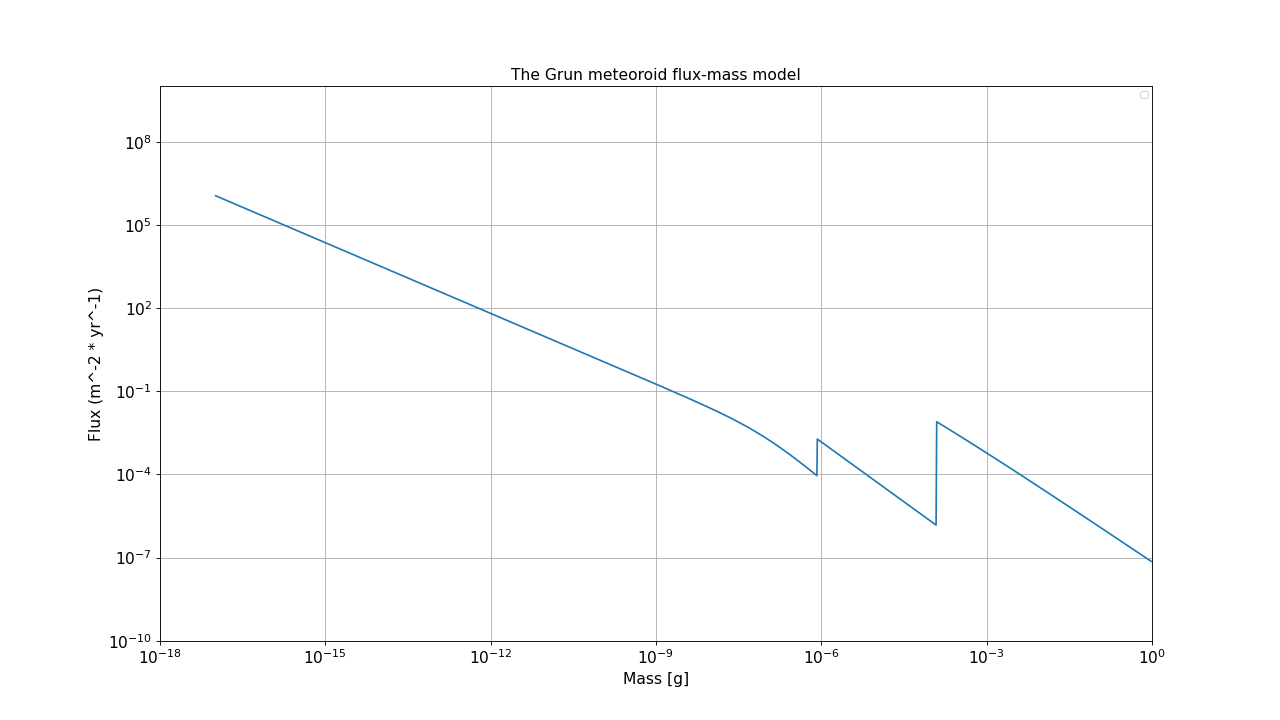

In [240]:
%matplotlib widget
fig = plt.figure(figsize=(16,9),dpi=80,facecolor=(1,1,1))
ax = plt.subplot(1,1,1)
ax.loglog(mass, flux)
plt.xlim(1 * 10**-18, 1 * 10**0)
plt.ylim(1 * 10**-10, 1 * 10**10)
plt.grid()
ax.set_title(f"The Grun meteoroid flux-mass model", \
                         **{'fontname':'Corbel Light'}, loc='center', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(loc="upper right", prop={'size': 8})
ax.set_xlabel('Mass [g]', fontsize=14)
ax.set_ylabel("Flux (m^-2 * yr^-1)", fontsize=14)

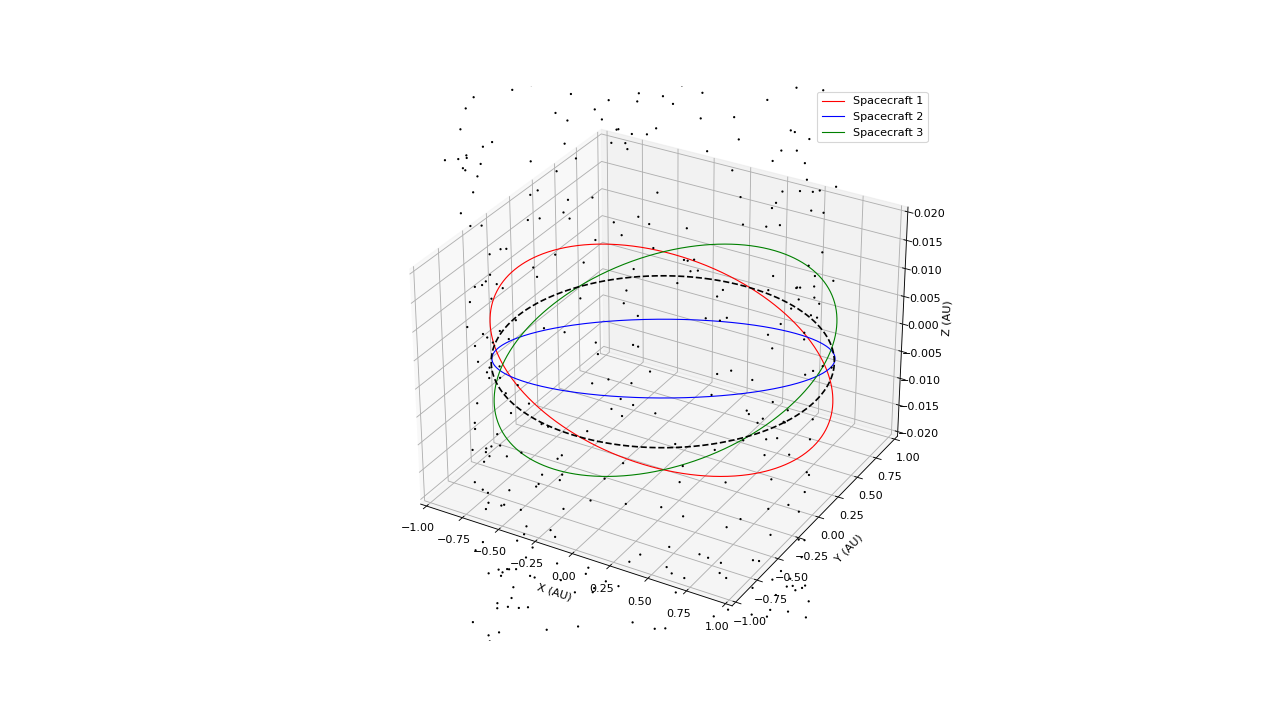

In [235]:
n = 10000
# Generate random orbital parameters for 1000 asteroids
a = np.random.uniform(0.95, 1.05, size=n)
ecc = np.random.weibull(2.24, size=n) * 0.158
inc = np.random.normal(0, 2.57, size=n)
inc[np.abs(inc) > 10] = np.random.normal(0, 2.57, size=np.sum(np.abs(inc) > 10))

# Convert orbital elements to Cartesian coordinates
mu = 1.32712440018e20  # Gravitational parameter of the Sun
n = np.sqrt(mu / a**3)
x = a * (np.cos(n) - ecc)
y = a * np.sqrt(1 - ecc**2) * np.sin(n)
z = a * np.sin(inc)

# Define the time range for the plot
t = np.linspace(0, 2*np.pi, 1000)

# Define the orbital parameters for Earth
a = 1.00000011 # AU
e = 0.01671022
inc = np.radians(0.00005)
Omega = np.radians(-11.26064)
omega = np.radians(114.20783)
M = np.radians(357.51716)

# Calculate the position and velocity vectors for Earth at each time step
r   = a*(1 - e**2)/(1 + e*np.cos(M + t))
xE  = r*(np.cos(Omega)*np.cos(omega + t) - np.sin(Omega)*np.sin(omega + t)*np.cos(inc))
yE  = r*(np.sin(Omega)*np.cos(omega + t) + np.cos(Omega)*np.sin(omega + t)*np.cos(inc))
zE  = r*np.sin(inc)
vxE = -np.sqrt(1 - e**2)*a*np.sin(M + t)/r*np.sin(omega + t)
vyE = np.sqrt(1 - e**2)*a*np.sin(M + t)/r*np.cos(omega + t)
vzE = 0

# Create the figure and axes
fig = plt.figure(figsize=(16,9), dpi=80, facecolor=(1,1,1))
ax = fig.add_subplot(111, projection='3d')

# Read in the data and plot the spacecraft orbits
with h5py.File('/home/lisauser/workspace/MeteoroidImpactAnalysis/kepler-orbits-d1yr.h5', 'r') as f:
    sc_xyz = f['/tcb/x'][()][:, :3, :] / 1.496e+8
    colors = ['r', 'b', 'g']
    labels = ['Spacecraft 1', 'Spacecraft 2', 'Spacecraft 3']
    for i in range(3):
        ax.plot(sc_xyz[:, i, 0] / 1000, sc_xyz[:, i, 1] / 1000, sc_xyz[:, i, 2] / 1000, colors[i], linewidth=1, label=labels[i])

# Plot the asteroid orbits
ax.scatter(x, y, z, s=1, color='k',alpha=1)

# Plot Earth's Orbit
ax.plot(xE, yE, zE, 'k', linestyle = 'dashed')

# Set the axis labels and limits
ax.set_xlabel('X (AU)')
ax.set_ylabel('Y (AU)')
ax.set_zlabel('Z (AU)')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim([-2 * 10**-2, 2 * 10**-2])

# Add the legend
ax.legend()

# Show the plot
plt.show()
plt.tight_layout()